# Relatório Semanal de Consumo de Papelão nas Embalagens de Cadeiras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import xlsxwriter

from datetime import date, time, datetime
from pandas_ods_reader import read_ods
from pandas import Grouper
from pandas import ExcelWriter

# palette -> Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r
sns.set_palette("inferno")

# style -> white, dark, whitegrid, darkgrid, ticks
sns.set_style("darkgrid")

In [2]:
#Dados - Ocorrências
ocorrencias = read_ods("5W2H - Controle de Ocorrências.ods", sheet='ocorrencias')
ocorrencias['Faturado em'] = pd.to_datetime(ocorrencias['Faturado em'], format='%Y/%m/%d')
ocorrencias.set_index(ocorrencias['Faturado em'],inplace=True)
#ocorrencias = ocorrencias[ocorrencias['Nome do Cliente'] != 'MUNICIPIO DE SALVADOR']
#ocorrencias.dropna(inplace=True)

ocorrencias_caixas = ocorrencias[(ocorrencias['Análise'] == 'Chamado #29362')]

#Dados - Apontamento
exp_logix = pd.read_excel('Apontamento.xlsx', sheet_name='exp_logix')
exp_logix = exp_logix[exp_logix['Quantidade de peças atendidas'] != 0]
print('* Desconsiderando os pedidos faturados com quantidade 0.')

exp_logix['Data último faturamento'] = pd.to_datetime(exp_logix['Data último faturamento'], format='%Y/%m/%d')
exp_logix.set_index(exp_logix['Data último faturamento'],inplace=True)

filter2 = (exp_logix['Linha produto'] == 1) | (exp_logix['Linha produto'] == 2) | (exp_logix['Denominação'].str.contains('CAD'))| (exp_logix['Denominação'].str.contains('POLT'))
exp_logix_estofados = exp_logix[filter2]

#apon = pd.read_excel('Apontamento.xlsx', sheet_name='apon')
#apon['Data Apont'] = pd.to_datetime(apon['Data Apont'], format='%Y/%m/%d')
#apon.set_index(apon['Data Apont'],inplace=True)

#filter3 = apon['Data Apont'] == 'E'
#apontamento_estofados = apon[filter3]

* Desconsiderando os pedidos faturados com quantidade 0.


In [3]:
hoje = date.today().strftime('%d/%m/%Y')
menor_data = ocorrencias_caixas['Faturado em'].min().strftime('%d/%m/%Y')
maior_data = ocorrencias_caixas['Faturado em'].max().strftime('%d/%m/%Y')

print(f'Hoje é {hoje}.\nO período avaliado compreende de {menor_data} até {maior_data}.')

Hoje é 27/07/2020.
O período avaliado compreende de 07/05/2020 até 24/07/2020.


In [4]:
#Agrupando Ocorrências
somatorio_ocorrencias_caixas = pd.DataFrame(ocorrencias_caixas.groupby([Grouper(key='Faturado em',freq='D'), 'Pedido','Item', 'G1', 'G2', 'G3', 'G4', 'G5'])['Qtde. NC'].max())
somatorio_ocorrencias_caixas.reset_index(inplace=True)
somatorio_ocorrencias_caixas = pd.DataFrame(somatorio_ocorrencias_caixas.groupby([Grouper(key='Faturado em',freq='W-SAT')])['Qtde. NC'].sum())
somatorio_ocorrencias_caixas.index.rename('Semana', inplace=True)

#Agrupando Apontamentos
fat_exp_logix_estofados = pd.DataFrame(exp_logix_estofados.groupby(Grouper(key='Data último faturamento', freq='W-SAT'))['Quantidade de peças atendidas'].sum())

#Agrupando Ocorrências + Apontamentos
somatorio_ocorrencias_caixas['Total de Cadeiras Faturadas'] = fat_exp_logix_estofados['Quantidade de peças atendidas']
somatorio_ocorrencias_caixas['Total de Cadeiras no Plástico'] = (fat_exp_logix_estofados['Quantidade de peças atendidas']-somatorio_ocorrencias_caixas['Qtde. NC'])
somatorio_ocorrencias_caixas['% do Total de Cadeiras Faturadas com Plástico'] = (somatorio_ocorrencias_caixas['Total de Cadeiras no Plástico']/somatorio_ocorrencias_caixas['Total de Cadeiras Faturadas'])*100
somatorio_ocorrencias_caixas['% Acumulado (Cadeiras sem Caixas)'] = (somatorio_ocorrencias_caixas['Total de Cadeiras no Plástico'].cumsum()/somatorio_ocorrencias_caixas['Total de Cadeiras Faturadas'].cumsum())*100

In [5]:
print('SOMATÓRIO DE OCORRÊNCIAS REGISTRADAS POR SEMANA')
somatorio_ocorrencias_caixas.fillna(0).round(2).to_period('W').reset_index().rename(columns={'Qtde. NC':'Total de Cadeiras com Caixa'})

SOMATÓRIO DE OCORRÊNCIAS REGISTRADAS POR SEMANA


,Semana,Total de Cadeiras com Caixa,Total de Cadeiras Faturadas,Total de Cadeiras no Plástico,% do Total de Cadeiras Faturadas com Plástico,% Acumulado (Cadeiras sem Caixas)
0,2020-05-04/2020-05-10,10.0,333,323.0,97.00,97.00
1,2020-05-11/2020-05-17,368.0,558,190.0,34.05,57.58
2,2020-05-18/2020-05-24,127.0,401,274.0,68.33,60.91
3,2020-05-25/2020-05-31,875.0,2543,1668.0,65.59,64.02
4,2020-06-01/2020-06-07,51.0,152,101.0,66.45,64.11
5,2020-06-08/2020-06-14,121.0,226,105.0,46.46,63.16
6,2020-06-15/2020-06-21,417.0,1052,635.0,60.36,62.60
7,2020-06-22/2020-06-28,129.0,371,242.0,65.23,62.78
8,2020-06-29/2020-07-05,389.0,544,155.0,28.49,59.76
9,2020-07-06/2020-07-12,89.0,185,96.0,51.89,59.53


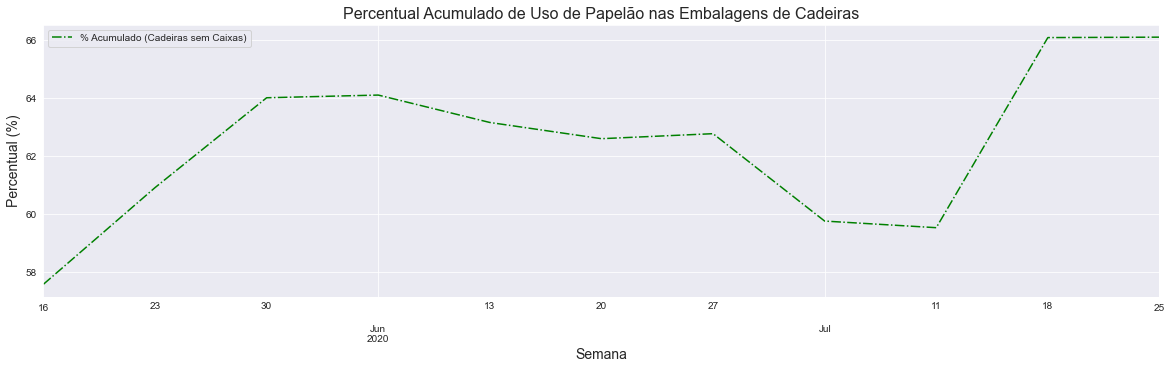

* DESCONSIDERANDO A PRIMEIRA SEMANA


In [6]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.set_title('Percentual Acumulado de Uso de Papelão nas Embalagens de Cadeiras', fontsize=16)
ax.set_ylabel('Percentual (%)', fontsize=14)
ax.set_xlabel('Semana', fontsize=14)
ax = somatorio_ocorrencias_caixas['% Acumulado (Cadeiras sem Caixas)'].tail(somatorio_ocorrencias_caixas.shape[0]-1).plot(linestyle='-.',color='green', legend=True)
plt.savefig('Papelão.png')
plt.show(ax)
print('* DESCONSIDERANDO A PRIMEIRA SEMANA')

In [7]:
#Exportando para 'consumo_papelao.xlsx':

with ExcelWriter('G:\PUBLICO\consumo_papelao.xlsx') as writer:
    ocorrencias_caixas.to_excel(writer, index=False, sheet_name='ocorrencias_caixas')